In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os

from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_cifar10

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

In [39]:
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/CIFAR10/Adversarial PGD/regularisation")
# path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/CIFAR10/vanilla")
file = "L2_1e-05.pth"
# file = 'model_1.pth'
pretrained_model = os.path.join(path, file)
use_cuda = True

In [40]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.zeros(1, 512)   # mask for the forwardMask function for pruning
    

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self.activations.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))*self.mask
        x = self.fc3(x)
        return x

    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    
# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

In [41]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)    
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [42]:
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

c: 0.001  Accuracy: 0.664  Distance: 0.0
c: 0.01  Accuracy: 0.665  Distance: 0.012
c: 0.025  Accuracy: 0.66  Distance: 0.028
c: 0.05  Accuracy: 0.658  Distance: 0.051
c: 0.1  Accuracy: 0.654  Distance: 0.095
c: 0.2  Accuracy: 0.6  Distance: 0.177
c: 0.3  Accuracy: 0.553  Distance: 0.248
c: 0.4  Accuracy: 0.505  Distance: 0.301
c: 0.5  Accuracy: 0.47  Distance: 0.355
c: 0.75  Accuracy: 0.385  Distance: 0.472
c: 1  Accuracy: 0.327  Distance: 0.549
c: 2.5  Accuracy: 0.193  Distance: 0.769


In [43]:
print(accuracies, distances)

[0.664, 0.665, 0.66, 0.658, 0.654, 0.6, 0.553, 0.505, 0.47, 0.385, 0.327, 0.193] [0.0, 0.012, 0.028, 0.051, 0.095, 0.177, 0.248, 0.301, 0.355, 0.472, 0.549, 0.769]


In [44]:
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.001  Accuracy: 0.665
eps: 0.002  Accuracy: 0.662
eps: 0.003  Accuracy: 0.662
eps: 0.004  Accuracy: 0.652
eps: 0.005  Accuracy: 0.649
eps: 0.006  Accuracy: 0.644
eps: 0.01  Accuracy: 0.619
eps: 0.015  Accuracy: 0.584
eps: 0.03  Accuracy: 0.446
eps: 0.06  Accuracy: 0.266
eps: 0.1  Accuracy: 0.177
[0.665, 0.662, 0.662, 0.652, 0.649, 0.644, 0.619, 0.584, 0.446, 0.266, 0.177]


# Results

In [63]:
# L2
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]
data = {
        'Baseline model': [0.732, 0.313, 0.16, 0.127, 0.116, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113],
        'PGD adversarial model': [0.677, 0.675, 0.674, 0.669, 0.662, 0.619, 0.597 , 0.557, 0.525, 0.439, 0.367, 0.198]
}

In [64]:
# Distance
data_2 = {
        '0': [0.028, 0.125, 0.178, 0.204, 0.233, 0.276, 0.309, 0.33, 0.345, 0.384, 0.404, 0.497],
        'PGD': [0.001, 0.009, 0.024, 0.047, 0.091, 0.157, 0.218, 0.276 , 0.32]
}

In [65]:
# Linf
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]
data_3 = {
        'Baseline model': [0.757, 0.694, 0.609, 0.531, 0.471, 0.407, 0.234, 0.139, 0.113, 0.113, 0.113],
        'PGD adversarial model': [0.676, 0.677, 0.667, 0.667, 0.651, 0.647, 0.626, 0.586, 0.465, 0.268, 0.183]
}

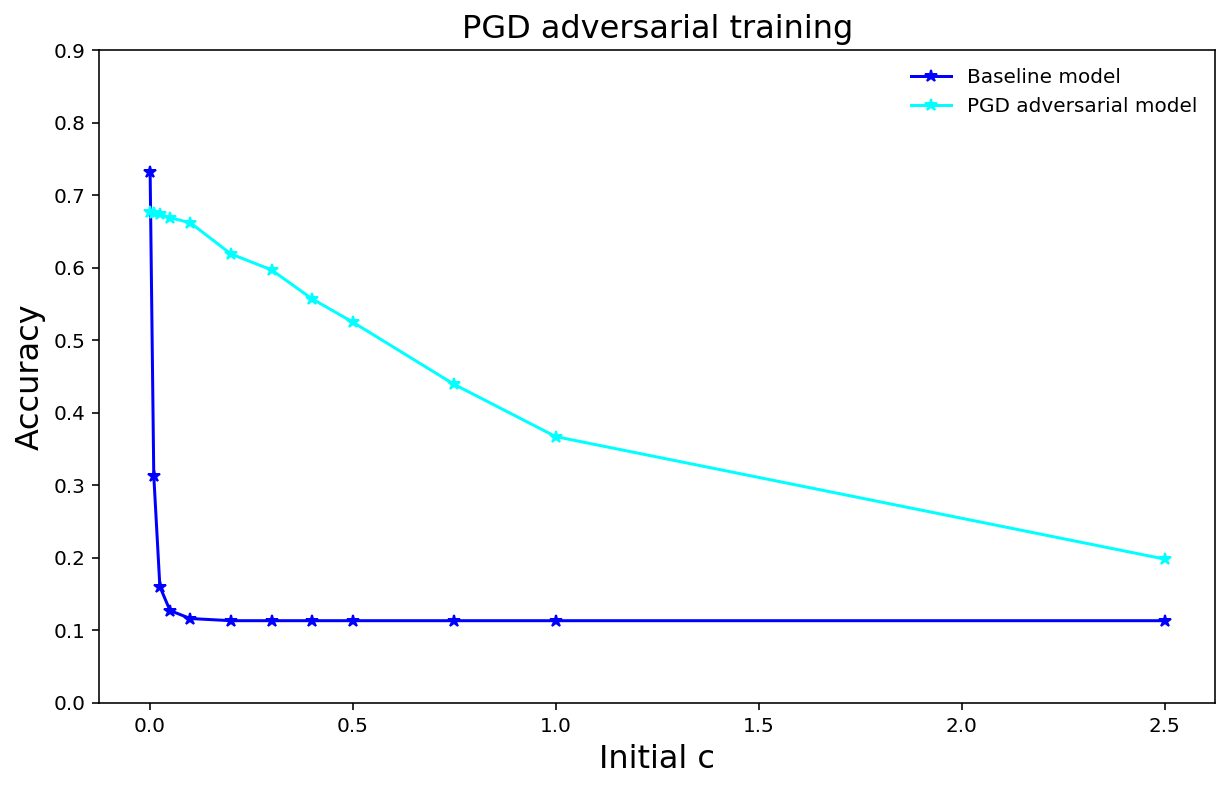

In [66]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['blue', 'cyan']

for idx, (l, results) in enumerate(data.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("PGD adversarial training",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

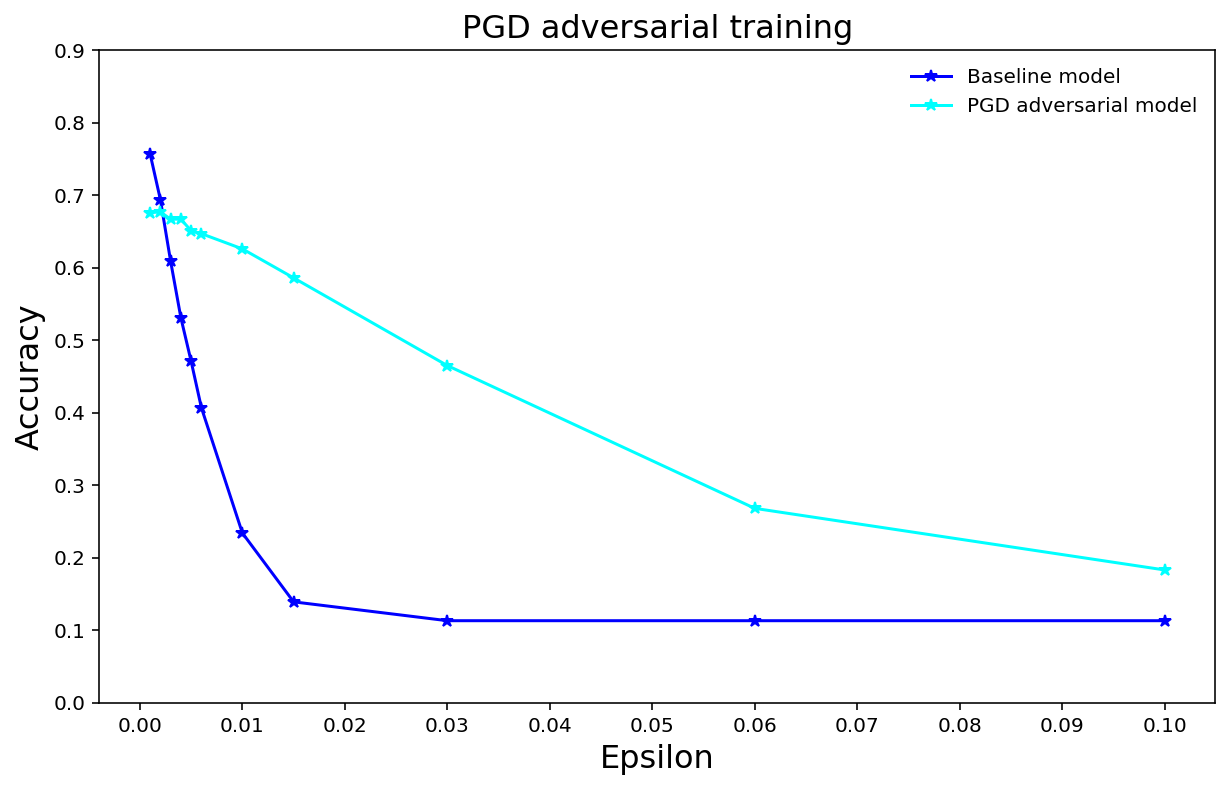

In [68]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['blue', 'cyan']

for idx, (l, results) in enumerate(data_3.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("PGD adversarial training",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

### Quantisation PGD

In [21]:
# L2
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]
data = {
        'Baseline model': [0.732, 0.313, 0.16, 0.127, 0.116, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113],
        'PGD adversarial model': [0.677, 0.675, 0.674, 0.669, 0.662, 0.619, 0.597 , 0.557, 0.525, 0.439, 0.367, 0.198],
        'QAT adversarial model': [0.638, 0.643, 0.639, 0.642, 0.633, 0.606, 0.561, 0.539, 0.506, 0.433, 0.379, 0.213]
}

In [28]:
# Distance
data_2 = {
        'Baseline model': [0.028, 0.125, 0.178, 0.204, 0.233, 0.276, 0.309, 0.33, 0.345, 0.384, 0.404, 0.497],
        'PGD adversarial model': [0.001, 0.009, 0.024, 0.047, 0.091, 0.157, 0.218, 0.276 , 0.32, 0.42, 0.51, 0.80],
        'QAT adversarial model': [0.002, 0.011, 0.028, 0.052, 0.091, 0.157, 0.222, 0.27, 0.312, 0.41, 0.479, 0.736]
}

In [29]:
# Linf
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]
data_3 = {
        'Baseline model': [0.757, 0.694, 0.609, 0.531, 0.471, 0.407, 0.234, 0.139, 0.113, 0.113, 0.113],
        'PGD adversarial model': [0.676, 0.677, 0.667, 0.667, 0.651, 0.647, 0.626, 0.586, 0.465, 0.268, 0.183],
        'QAT adversarial model': [0.639, 0.64, 0.642, 0.636, 0.637, 0.648, 0.626, 0.598, 0.473, 0.287, 0.187]
}

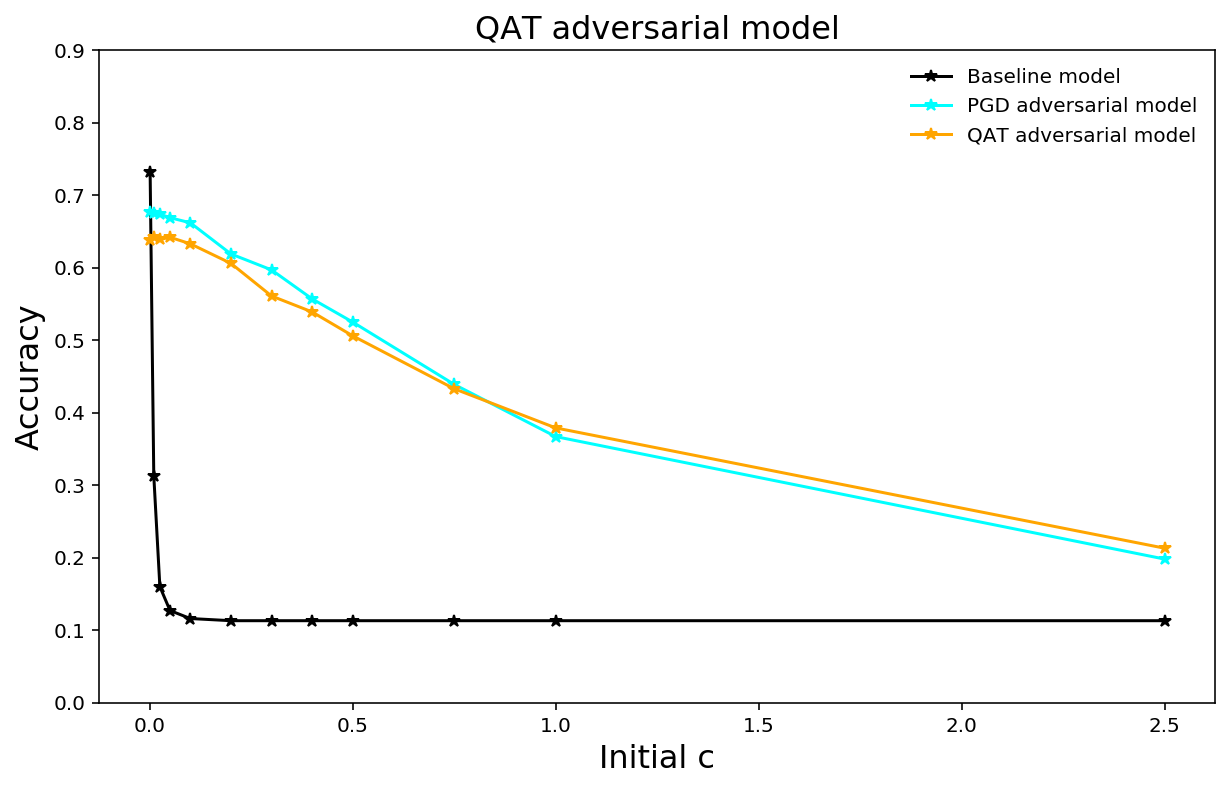

In [30]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'orange']

for idx, (l, results) in enumerate(data.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("QAT adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

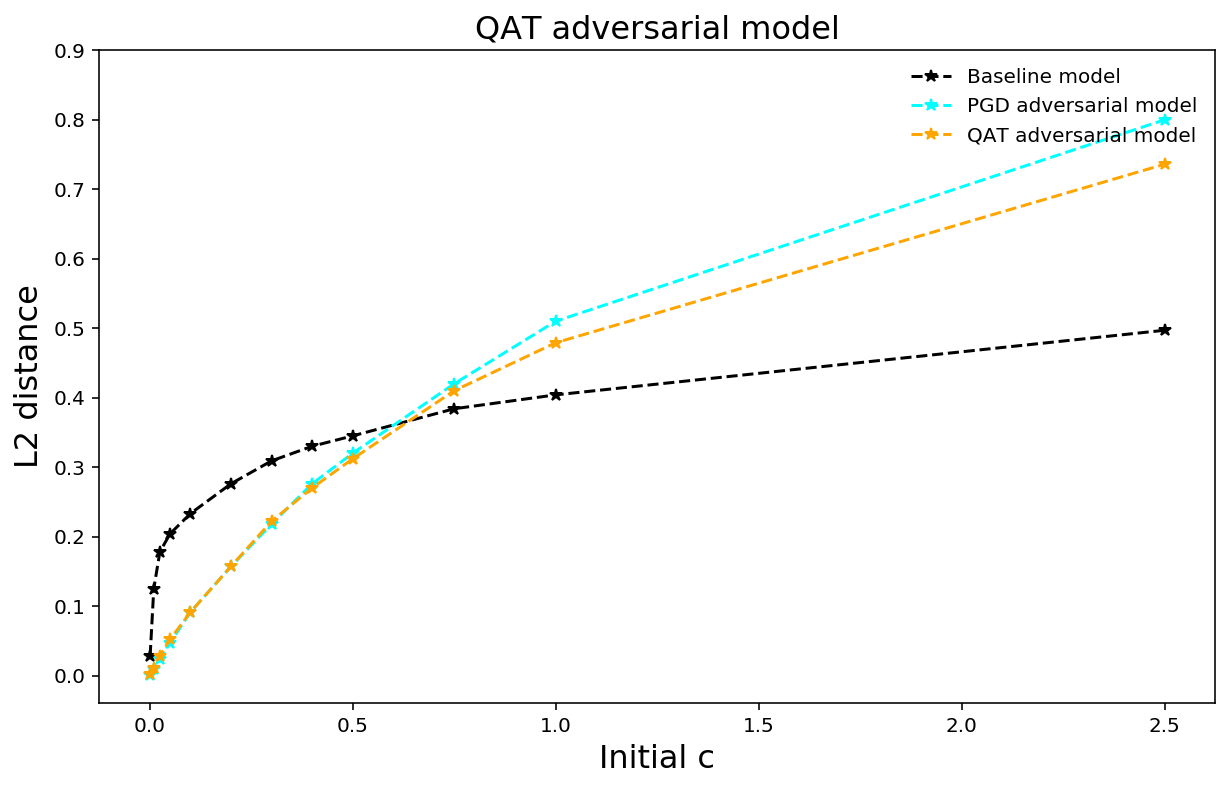

In [31]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'orange']

for idx, (l, results) in enumerate(data_2.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("QAT adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

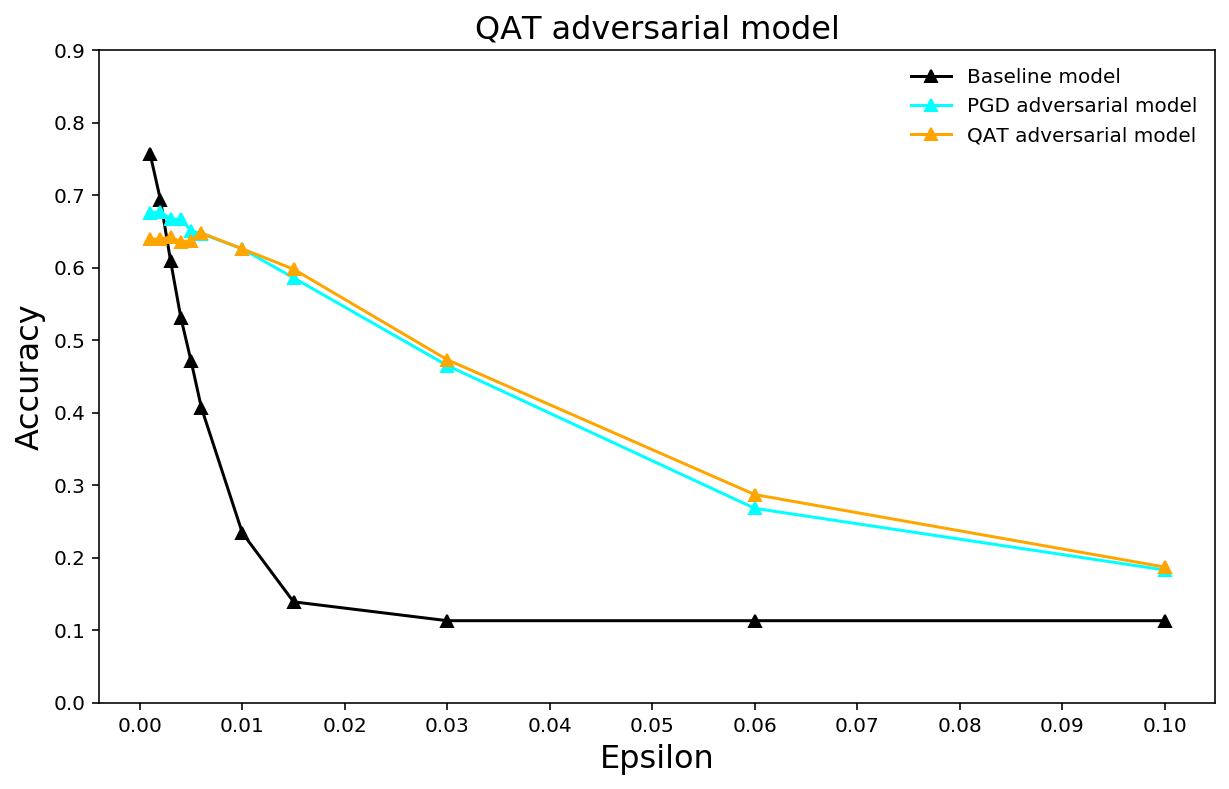

In [26]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'orange']

for idx, (l, results) in enumerate(data_3.items()):
    plt.plot(epsilons, results, "^-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("QAT adversarial model",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

### Regularisation PGD

In [9]:
# L2
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]
data = {
        'Baseline model': [0.732, 0.313, 0.16, 0.127, 0.116, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113],
        'PGD adversarial model': [0.677, 0.675, 0.674, 0.669, 0.662, 0.619, 0.597 , 0.557, 0.525, 0.439, 0.367, 0.198],
        '1e-03': [0.649, 0.648, 0.649, 0.648, 0.635, 0.617, 0.59, 0.565, 0.542, 0.472, 0.418, 0.211],
        '1e-04': [0.67, 0.665, 0.665, 0.659, 0.642, 0.617, 0.575, 0.549, 0.519, 0.439, 0.368, 0.197],
        '1e-05': [0.664, 0.665, 0.66, 0.658, 0.654, 0.6, 0.553, 0.505, 0.47, 0.385, 0.327, 0.193] 
}

# Distance
data_2 = {
        'Baseline model': [0.028, 0.125, 0.178, 0.204, 0.233, 0.276, 0.309, 0.33, 0.345, 0.384, 0.404, 0.497],
        'PGD adversarial model': [0.001, 0.009, 0.024, 0.047, 0.091, 0.157, 0.218, 0.276 , 0.32, 0.42, 0.51, 0.80],
        '1e-03': [0.001, 0.007, 0.018, 0.037, 0.077, 0.139, 0.197, 0.253, 0.298, 0.395, 0.478, 0.799],
        '1e-04': [0.001, 0.008, 0.025, 0.05, 0.094, 0.153, 0.22, 0.29, 0.339, 0.454, 0.561, 0.837],
        '1e-05': [0.0, 0.012, 0.028, 0.051, 0.095, 0.177, 0.248, 0.301, 0.355, 0.472, 0.549, 0.769],
}

epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]

data_3 = {
        'Baseline model': [0.757, 0.694, 0.609, 0.531, 0.471, 0.407, 0.234, 0.139, 0.113, 0.113, 0.113],
        'PGD adversarial model': [0.676, 0.677, 0.667, 0.667, 0.651, 0.647, 0.626, 0.586, 0.465, 0.268, 0.183],
        '1e-03': [0.648, 0.645, 0.646, 0.64, 0.637, 0.626, 0.613, 0.585, 0.468, 0.28, 0.18],
        '1e-04': [0.669, 0.671, 0.661, 0.657, 0.653, 0.647, 0.609, 0.59, 0.475, 0.277, 0.188],
        '1e-05': [0.665, 0.662, 0.662, 0.652, 0.649, 0.644, 0.619, 0.584, 0.446, 0.266, 0.177],
}

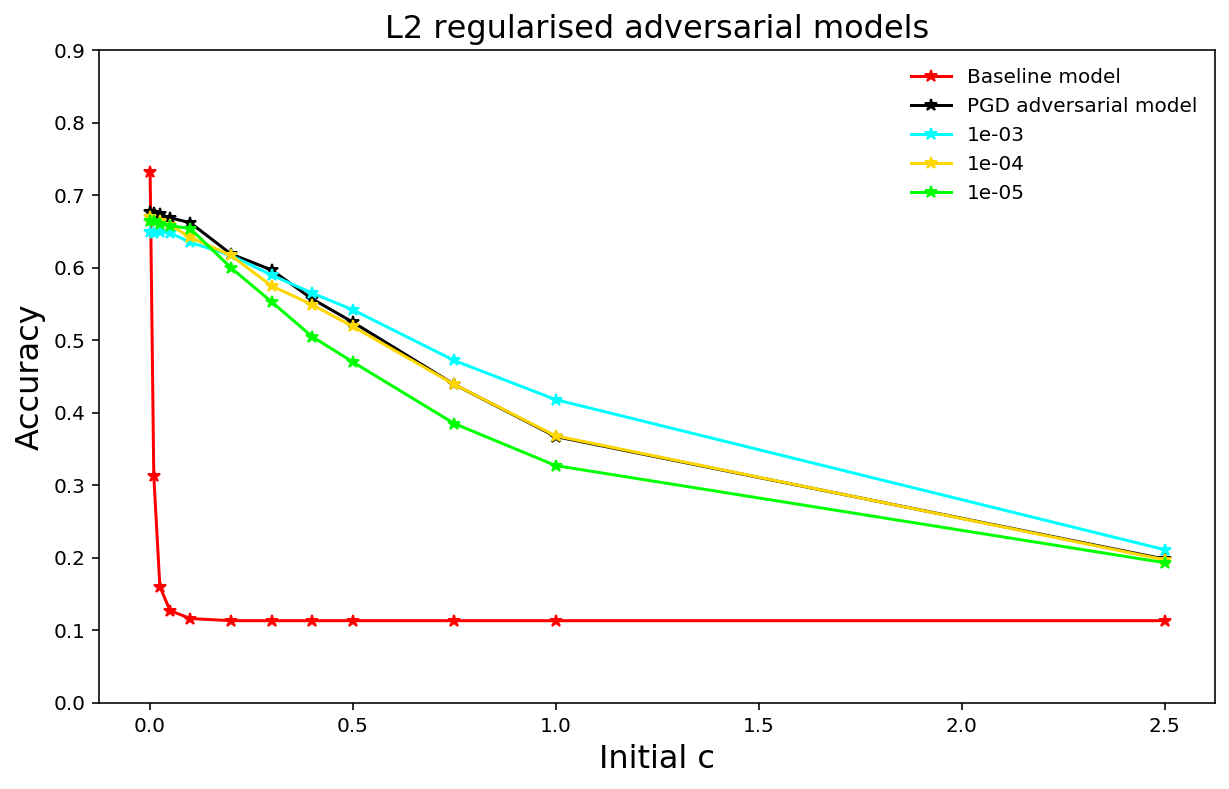

In [10]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'black', 'cyan', 'gold', 'lime']

for idx, (l, results) in enumerate(data.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

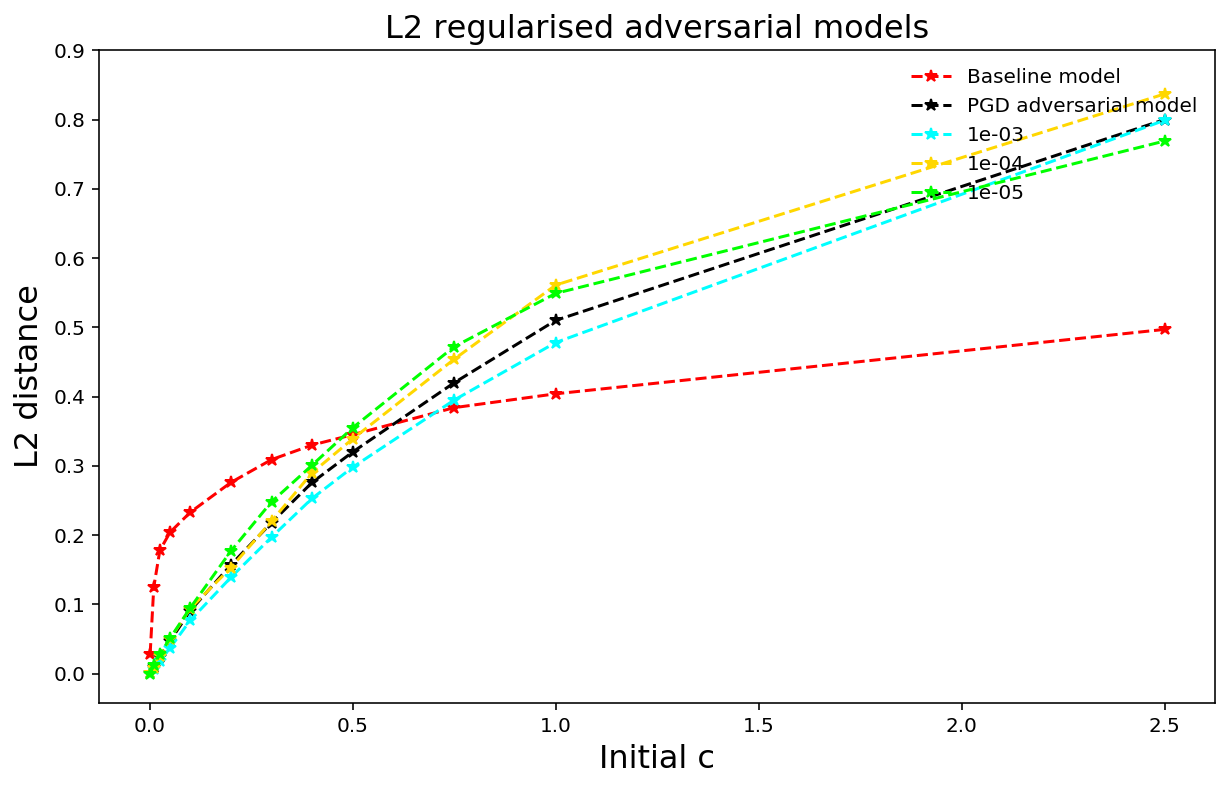

In [5]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'black', 'cyan', 'gold', 'lime']

for idx, (l, results) in enumerate(data_2.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

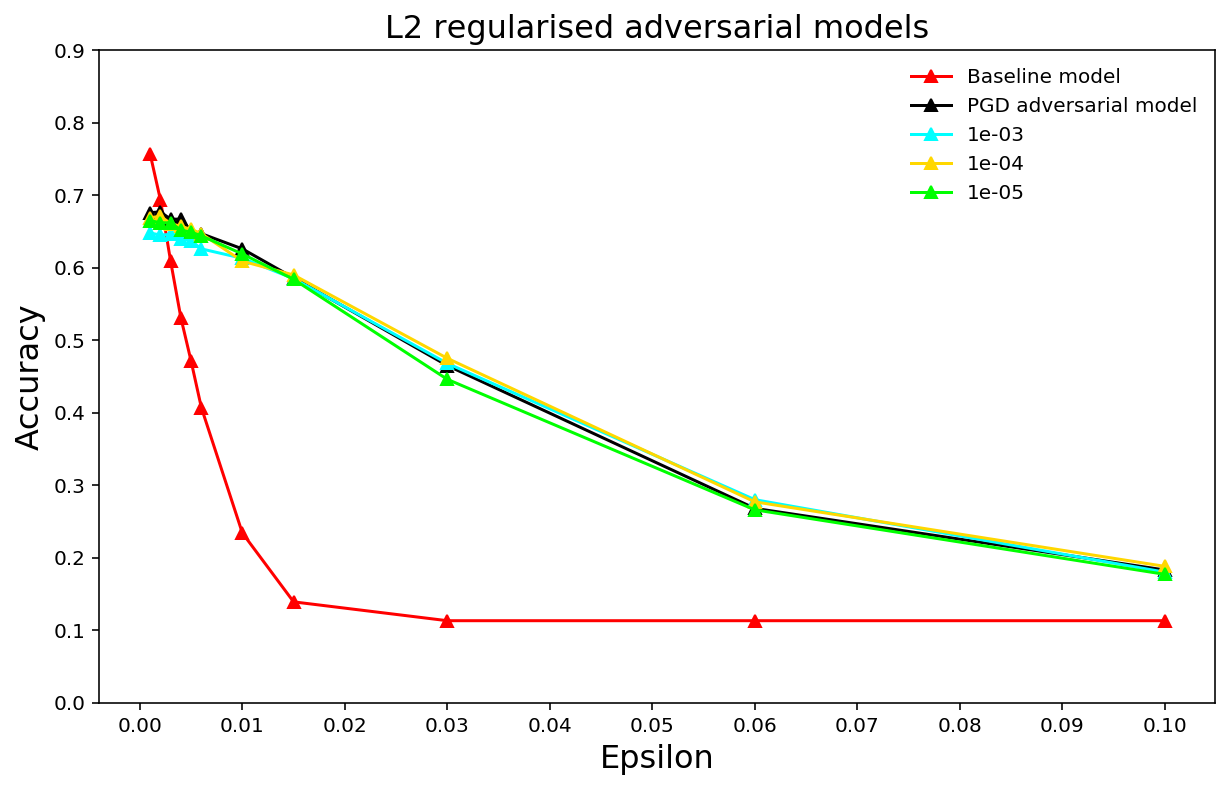

In [6]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'black', 'cyan', 'gold', 'lime']

for idx, (l, results) in enumerate(data_3.items()):
    plt.plot(epsilons, results, "^-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()